# Exploring Scottish Public Sector Workforce Diversity Data

<a href = "./shiny_psed_data.txt">Data download</a>

## Introduction

<p>This notebook presents some basic descriptive analysis of data on ethnic diversity in Scottish public sector workforces. The data has been collated from workforce monitoring reports published by Scottish councils. These reports are produced under the Public Sector Equality Duty (PSED), which was brought in by the 2010 Equality Act. This Duty seeks to ensure public organisations actively work to promote equality and eliminate discrimination based on protected characteristics, such as gender, ethnicity, sexual orientation, disability and transgender identity etc. As part of this, since 2011, councils in Scotland have been obliged to collect and publish statistics on their workforces regardings these protected characteristics. This is both to help tackle inequalities in hiring, training, retention and grievance practices, and to ensure that public bodies are able to adequately provide services for the public by being representative of their communities. Between 2011 and the present, each council should have produced reports every two years, resulting in multiple rounds of data, however the data is not reported consistently and in some cases has not been reported at all.</p>

<p>This notebook was produced during a research project exploring the PSED data. The aim here was to bring together what has previously been figures published disparately, in different places and on different timescales, and to ensure comparability and present them as a useable dataset. The dataset consists of all available ethnicity data from each council, along with some select measures of other protected characteristics (gender, sexual orientation and marital status). In the analysis below, we give a brief overview of the ethnic profile of council workforces in Scotland, and also to highlight some of the issues within the data.</p>


## Structure of the Data

<p>We'll firstly take a quick look at the structure of the data. Using `head(df, 10)` gives us a look at the dataset.</p>

In [1]:
# Quietly install, if necessary, and then load packages for the notebook
suppressMessages({
    if (!require("pacman")) install.packages("pacman")
    pacman::p_load(
        rgdal,
        ggplot2,
        ggrepel,
        dplyr,
        tidyr,
        leaflet,
        leaflet.extras,
        sf,
        raster,
        DescTools,
        lubridate,
        IRdisplay
    )
})

# Read in data
df<- read.csv("shiny_psed_data.csv", header = TRUE)

# Get top 10 rows
head(df, 10)

,lad19cd,council,pub_year,year,section,blank,nondisc,unknown,white,bme,...,nondisc_sexuality,unknown_sexuality,heterosexual,all_other_sexualities,blank_marital,nondisc_marital,unknown_marital,notes,link,bmepop
,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,S12000033,Aberdeen City,2019,2018,All,19.97,5.83,25.80,62.61,11.59,...,5.69,37.68,61.04,1.28,28.33,3.99,32.32,,https://www.aberdeencity.gov.uk/sites/default/files/2020-02/Appendix%202.pdf,8.114259
2,S12000033,Aberdeen City,2019,2017,All,18.13,6.18,24.31,63.46,12.23,...,6.01,37.30,61.36,1.34,29.10,3.80,32.90,,https://www.aberdeencity.gov.uk/sites/default/files/2020-02/Appendix%202.pdf,8.114259
3,S12000033,Aberdeen City,2017,2016,All,14.32,7.24,21.56,64.20,14.24,...,6.80,37.80,61.10,1.10,24.00,3.90,27.90,,https://www.aberdeencity.gov.uk/sites/default/files/ACC%20Employee%20Information.pdf,8.114259
4,S12000033,Aberdeen City,2017,2015,All,14.78,7.36,22.14,63.55,14.31,...,6.80,38.50,60.40,1.10,24.30,3.80,28.10,,https://www.aberdeencity.gov.uk/sites/default/files/ACC%20Employee%20Information.pdf,8.114259
5,S12000034,Aberdeenshire,2017,2016,All,NA,NA,33.45,65.36,1.19,...,NA,45.00,54.09,0.91,NA,NA,NA,,http://publications.aberdeenshire.gov.uk/dataset/d94d5751-0329-4fce-88ae-0355d1197da7/resource/43aa46f4-e053-48e2-be7c-6c8e9bfd71dd/download/mainstream-and-outcomes-report-2017-21.pdf,1.526250
6,S12000034,Aberdeenshire,2017,2015,All,NA,NA,21.46,77.01,1.53,...,NA,NA,NA,NA,NA,NA,NA,,http://publications.aberdeenshire.gov.uk/dataset/d94d5751-0329-4fce-88ae-0355d1197da7/resource/43aa46f4-e053-48e2-be7c-6c8e9bfd71dd/download/mainstream-and-outcomes-report-2017-21.pdf,1.526250
7,S12000041,Angus,2019,2018,All,26.56,8.37,34.93,64.12,0.95,...,0.52,84.76,15.05,0.19,53.08,0.07,53.15,,https://www.angus.gov.uk/sites/angus-cms/files/2019-04/140_app2_0.pdf,1.301971
8,S12000041,Angus,2017,2016,All,16.70,9.51,26.22,72.99,0.79,...,0.48,87.24,12.65,0.11,59.29,0.02,59.32,,https://www.angus.gov.uk/sites/angus-cms/files/2017-08/Equalities%20Mainstreaming%20Report%20and%20Equality%20Outcomes%20%282017-2019%29.pdf,1.301971
9,S12000041,Angus,2015,2014,All,6.58,11.82,18.39,81.11,0.50,...,NA,NA,NA,NA,NA,NA,NA,,https://www.angus.gov.uk/sites/angus-cms/files/2017-08/176%20Equalities%20Mainstreaming_Appendix%202.pdf,1.301971


<p>We see that the data is in long format, that is we have one row per each year that a council's workforce characteristics were measured.</p>
<p>The main variables of interest at the moment are described below:

| Variable | Description   |
|------|------|
|`council`| Which council this row refers to|
|`year`| Year the workforce was measured |
|`bme`| Percentage of workforce who are of any non-white ethnic minority |
|`white`| Percentage of workforce who are of any white ethnicity |
|`unknown`|Percentage of workforce with unknown ethnicity|

We can also see that we do not have the same number of years of reporting for each council. To get an idea of how much data we have for each council and each year, we can produce two basic bar plots.</p>

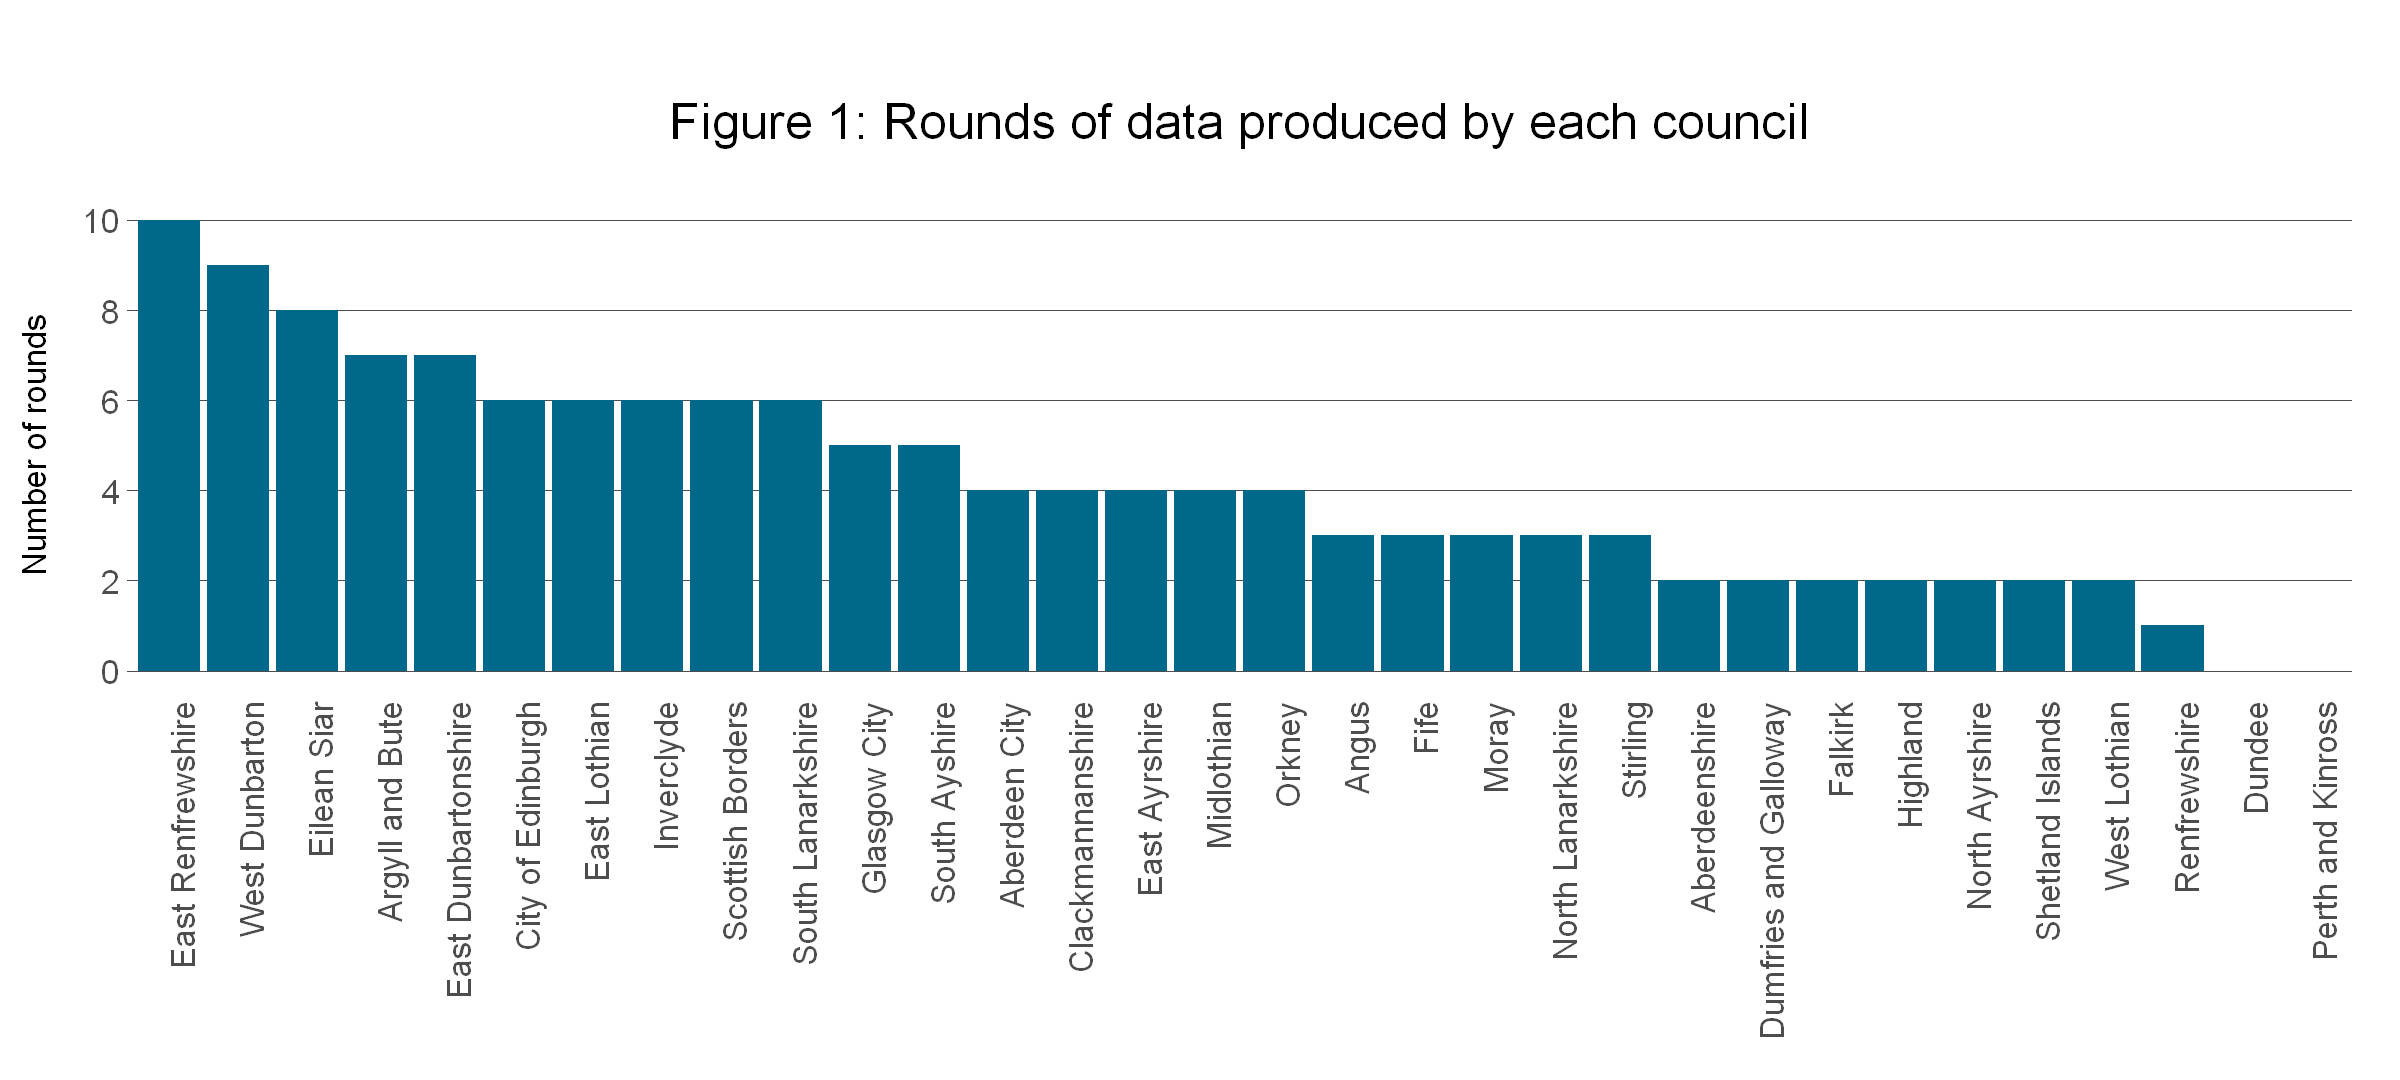

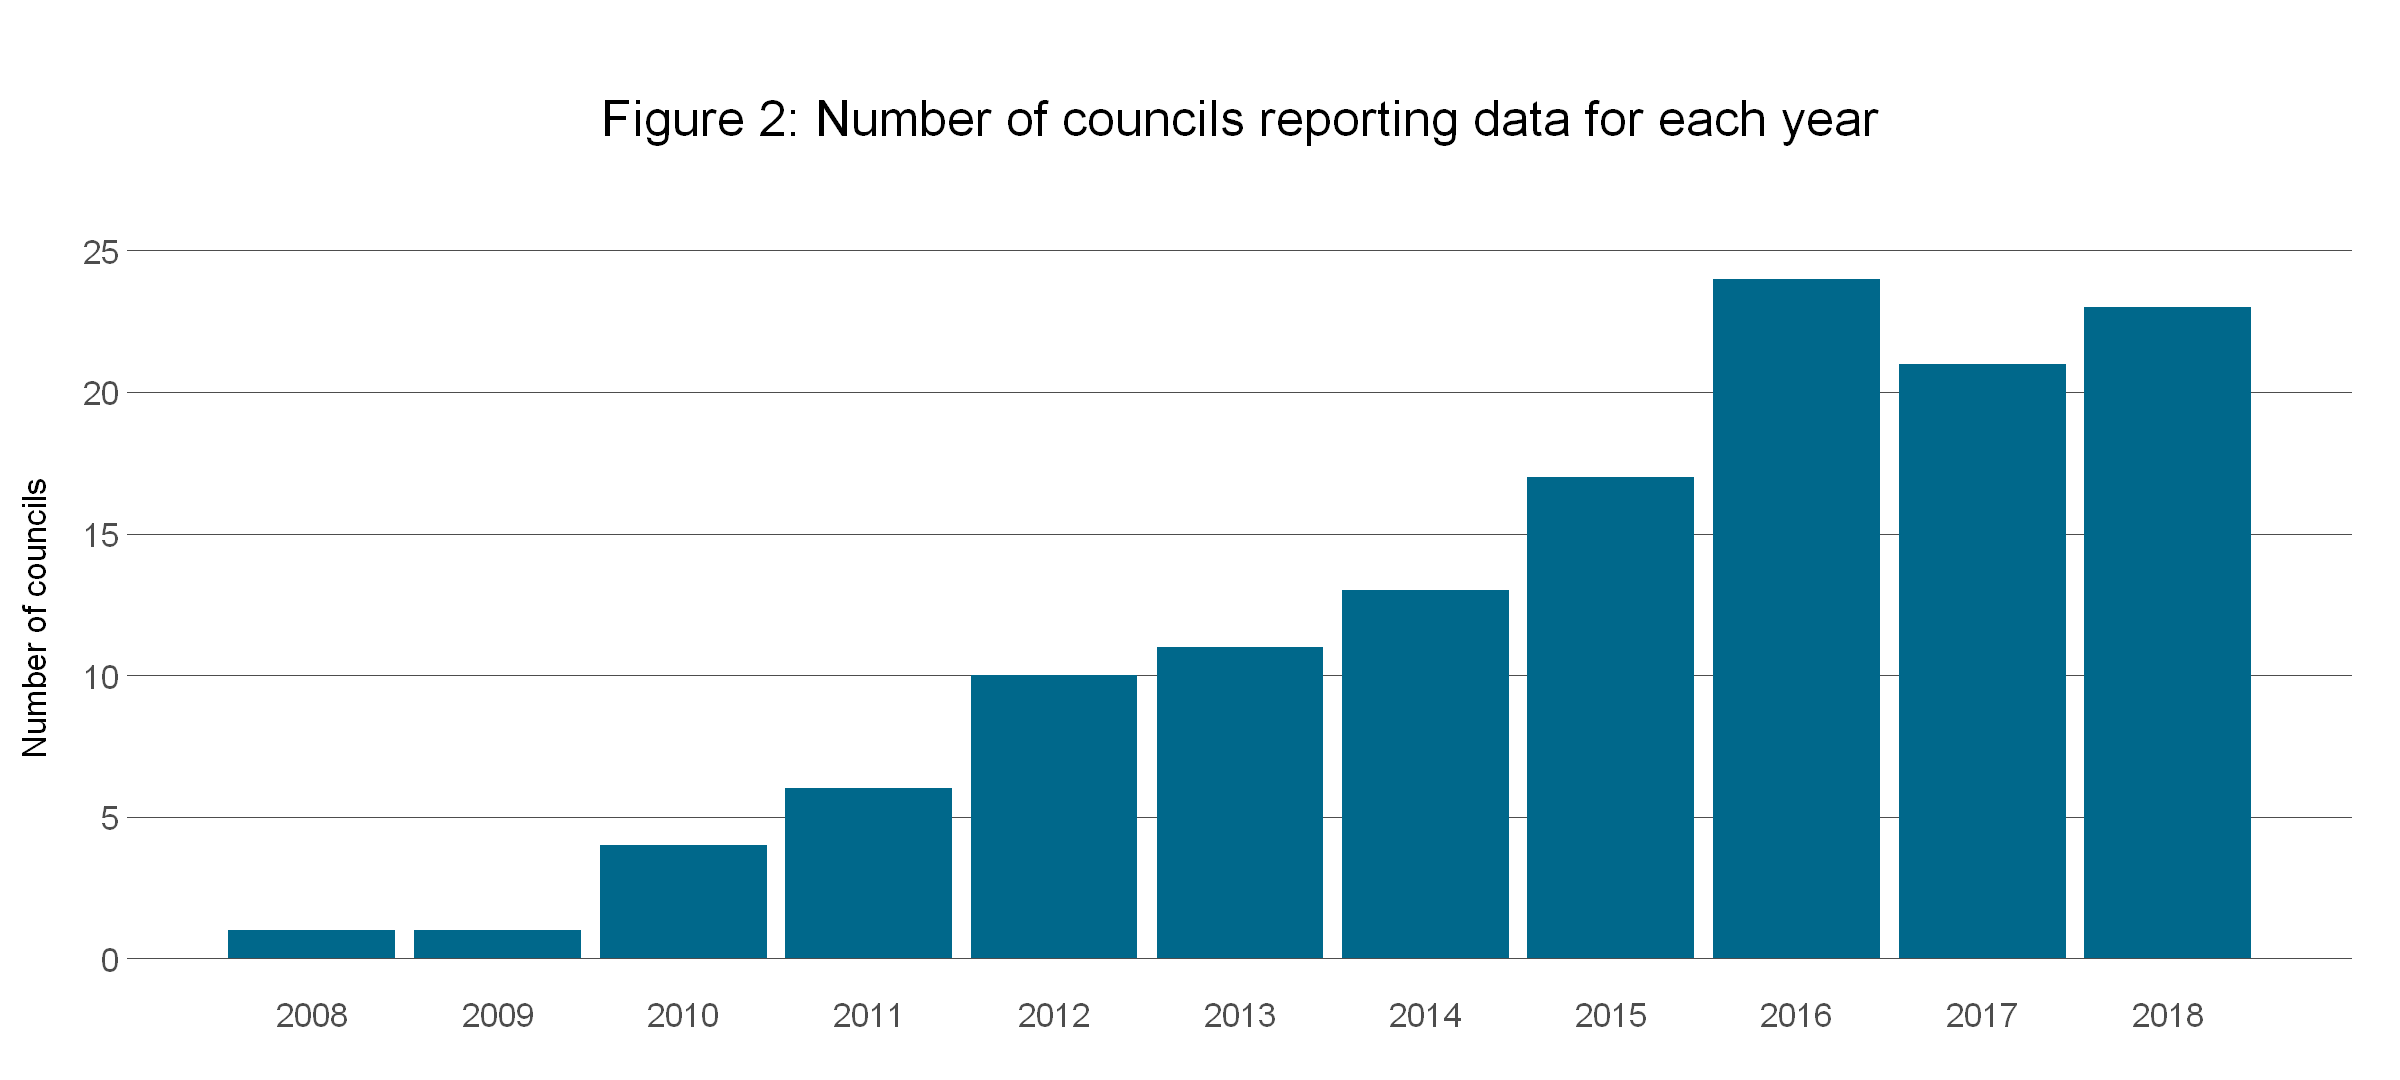

In [2]:
# Filter out rows with no ethnicity data
df<- filter(df, !is.na(bme))

# Convert the 'year' integer variable to a date variable using the Lubridate package
df$year_char<-paste0(df$year, "-01-01")
df$year<- ymd(df$year_char)
df<- df[,-ncol(df)]

# Produce plot of reports per council
options(repr.plot.width = 20, repr.plot.height = 9)

count(df, council, .drop = F)%>%
mutate(council = reorder(council, -n))%>%
ggplot()+
    geom_col(aes(x = council, y = n), fill = "#00688b")+
    scale_y_continuous(breaks = seq(0,10,2))+
    labs(y = "Number of rounds", title = "Figure 1: Rounds of data produced by each council")+
    theme(axis.text.y = element_text(size = 20),
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1),
    axis.title.y = element_text(size = 20, vjust = 5),
    axis.title.x = element_blank(),
    plot.title = element_text(size = 30, hjust = 0.5, vjust = 5),
    axis.ticks = element_blank(),
    panel.background = element_blank(),
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = "gray30"),
    plot.margin = unit(c(3,1,1,1), "cm")
    )

# Produce plot of reports per year
count(df, year, .drop = F)%>%
ggplot()+
    geom_col(aes(x = year, y = n), fill = "#00688b")+
    labs(y = "Number of councils", title = "Figure 2: Number of councils reporting data for each year")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    theme(axis.text.y = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.title.y = element_text(size = 20, vjust = 5),
    axis.title.x = element_blank(),
    plot.title = element_text(size = 30, hjust = 0.5, vjust = 10),
    axis.ticks = element_blank(),
    panel.background = element_blank(),
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = "gray30"),
    plot.margin = unit(c(4,1,1,1), "cm")
    )

<p>As can be seen from Figure 1, there is sunstantial variation in the number of rounds of data that each council has published. For two - Dundee Council and Perth and Kinross Council - we have no ethnicity data, whilst for East Renfrewshire we have 10 rounds. The mean number, however, is 4.3 rounds.</p>

<p>Figure 2 shows that only for recent years do we have data on a substantial number of councils. Prior to 2016, data is available from less than 20 councils out of the 32 in Scotland. This means that to get an accurate overview and in order to facilitate comparisons, we need to mainly limit our analysis to the latest three years of data.</p>

## Overview of the situation across Scotland
<p>Since we don't have data for every council for every year, to get a picture of the current situation across the country, we will have to take the latest available ethnicity figures from each local authority. Given that we are looking at workforces across the geographic areas of Scotland's councils, the data naturally lends itself to being presented in a map format, and so we use the Leaflet package to produce an interactive map presenting each council and the proportions of employees who are BME, White or who have an unknown ethnicity (we shall return to the issue of unknown ethnicity figures later). The boundaries data for the councils is sourced from the <a href = http://geoportal.statistics.gov.uk/ >Office for National Statistics Geoportal.</a></p>

<p>At the same time, in order to make the overview meaningful, we need to take into account the ethnic diversity of the local population in each local authority - comparing the BME proportions of council workforces in Glasgow and the Shetland Islands directly does not make sense given that Glasgow has a much more ethnically diverse population. This is especially important since, as previously mentioned, one of the main motivations of the PSED framework is to monitor whether that local authority employees are representative of the communities they serve.</p>

<p>To compare between the workforce and the local population, we can draw on 2011 Scottish Census data (sourced from the <a href = https://www.scotlandscensus.gov.uk/ods-web/standard-outputs.html >National Records of Scotland Census website</a>). Given that when we are looking at BME proportions, both in the council workforce and in the local population, we are dealing with very small numbers it can be misleading to just look at the absolute figures. A more useful way of comparing the two is to look at the workforce figure as a proportion of the population figure. To make this easy to interpret at a glance, the labels in the map put these proportions into words, describing the workforce proportion as being about half, or a quarter the size of the local population proportion etc. Whilst this means some of the precision is lost, it does give a quick and meaningful representation of whether the workforce is representative of the population.</p>

**Note: depending on where you are viewing this notebook, the interactive Leaflet Map may not render. To open the html file, <a href = "./psed_map.html">click here.</a>**

In [9]:
# Read in boundaries data
polys<- shapefile("Local_Authority_Districts_December_2019_Boundaries_UK_BUC.shp")
polys<- spTransform(polys, CRS("+proj=longlat +datum=WGS84"))
polys<- st_as_sf(polys)
scot<- polys[substr(polys$lad19cd, 1, 1)=="S",]

# Filter data for those with separate teaching and non-teaching
df<- df[df$section!="Teaching",]

# Convert some of the variable types
df2<- data.frame(lapply(df[,c(8, 9, 10, 22)], function(x) as.numeric(x)))
df2<- cbind(df[,c(-8, -9, -10, -22)], df2)

# Create dataframe with latest year for each council
l<- group_by(df2, council) %>%
        top_n(1, year)

# Join latest data to boundaries dataframe
l$lad19cd<- as.character(l$lad19cd)
scot<-left_join(scot, l, by = "lad19cd")
scot<- scot[order(scot$lad19nm),]
                        
# Calculate difference between workforce and population
scot$diff<- scot$bme - scot$bmepop
scot$percdiff<- (scot$bme-scot$bmepop)*100/scot$bmepop
scot$percdiff_round<- RoundTo(scot$percdiff, 25)
scot$percdiff_cat[scot$percdiff_round==-50]<- "half the size of"
scot$percdiff_cat[scot$percdiff_round==-25]<- "three quarters the size of"
scot$percdiff_cat[scot$percdiff_round==-75]<- "a quarter the size of"
scot$percdiff_cat[scot$percdiff_round==-100]<- "a tenth the size of"
scot$percdiff_cat[scot$percdiff_round==50]<- "one and a half times"
scot$percdiff_cat[scot$percdiff_round==75]<- "one and three quarters times"
scot$percdiff_cat[scot$percdiff_round==0]<- "nine tenths the size of"
scot$percdiff_cat[scot$percdiff_round==100]<- "twice the size of"
scot$diffcolour[scot$percdiff_round < 0]<- "#CD5C5C"
scot$diffcolour[scot$percdiff_round > 0]<- "#5F9EA0"

# Create a character variable from the date variable so that the year can be put into the labels
scot$yearc<- substr(as.character(scot$year), 1, 4)

# Replace the NA values in the section variable to allow the sprintf function to work
scot$section<- as.character(scot$section)
scot$section[is.na(scot$section)]<- "NA"

# Create map labels
scot$label<- sprintf(
  "<strong>%s Council</strong><br/>Latest ethnicity data available: %s<br/>Council workforce profile:<br/>%g&#37 BME<br/>%g&#37 White<br/>%g&#37 Unknown<br/><br/>The BME proportion in the council workforce is about<br/> <span style = 'font-weight:bold;color:%s'>%s</span> the proportion in the local population.",
  scot$lad19nm, scot$yearc, round(scot$bme, 1), round(scot$white, 1), round(scot$unknown, 1), scot$diffcolour, scot$percdiff_cat
) %>% 
  lapply(htmltools::HTML)

# Modify labels for councils with separate teaching and non-teaching data
scot$label[scot$section=="Non_Teaching"]<- sprintf(
  "<strong>%s Council</strong><br/>Latest ethnicity data available: %s<br/>Council workforce profile (non-teaching only):<br/>%g&#37 BME<br/>%g&#37 White<br/>%g&#37 Unknown<br/><br/>The BME proportion in the council workforce is about<br/> <span style = 'font-weight:bold;color:%s'>%s</span> the proportion in the local population.",
  scot$lad19nm[scot$section=="Non_Teaching"], scot$yearc[scot$section=="Non_Teaching"], round(scot$bme[scot$section=="Non_Teaching"], 1), round(scot$white[scot$section=="Non_Teaching"], 1), round(scot$unknown[scot$section=="Non_Teaching"], 1), scot$diffcolour[scot$section=="Non_Teaching"], scot$percdiff_cat[scot$section=="Non_Teaching"]
) %>% 
  lapply(htmltools::HTML)

# Modify labels for councils with no data
scot$label[is.na(scot$bme)]<- sprintf(
  "<strong>%s Council</strong><br/>Ethnicity data is not available.",
  scot$lad19nm[is.na(scot$bme)]
) %>% 
  lapply(htmltools::HTML)

# Create label for pointing to Orkney and Shetland Islands
labelinstr<- sprintf(
  "Drag North for<br/>Orkney and Shetland<br/>Islands"
) %>% 
  lapply(htmltools::HTML)
                        
# Produce Leaflet map
m<- leaflet(options = leafletOptions(minZoom = 5))
m<- addPolygons(data = scot, m, fillColor = "#00688b", color = "white", fillOpacity = 1, weight = 1, highlightOptions = highlightOptions(color = "darkred", weight = 2, bringToFront = TRUE), label = scot$label, labelOptions = labelOptions(textsize = "14px", opacity = 0.8))
m<- addLabelOnlyMarkers(m, lng = 1.3, lat = 58.5, label = labelinstr, labelOptions = labelOptions(direction = "bottom", noHide = TRUE, style = list("box-shadow" = "0px 0px")))
m<- setView(m, lng = -4, lat = 56.9, zoom = 6)
m<- setMapWidgetStyle(m, list(background = "white"))

display_html("</br><p style = 'font-size:20px;padding-left:200px'>Figure 3: The Ethnic Profile of Scottish Council Workforces</p></br></br>")
m

Figure 3: The Ethnic Profile of Scottish Council Workforces

HTML widgets cannot be represented in plain text (need html)

<p>Figure 3 provides a good way of displaying the data to a user. What can easily be seen by exploring the map is that the ethnic minority proportions in the workforces are almost always very small and also smaller than the proportion in the local population. Another point that stands out is that many councils have substantial proportions of their employees for whom the ethnicity is unknown. This suggests that the BME/White proportions cannot be taken at face-value and these unknown proportions require further invesitgation. We shall return to this issue later.</p>

<p>In Figure 3, however, we cannot view the councils simultaneously in order to compare them. To do this we can again produce simple bar charts giving the BME proportions in each workforce (Figure 4) and then the size of the BME workforce proportion relative to the BME local population proportion (Figure 5).</p>

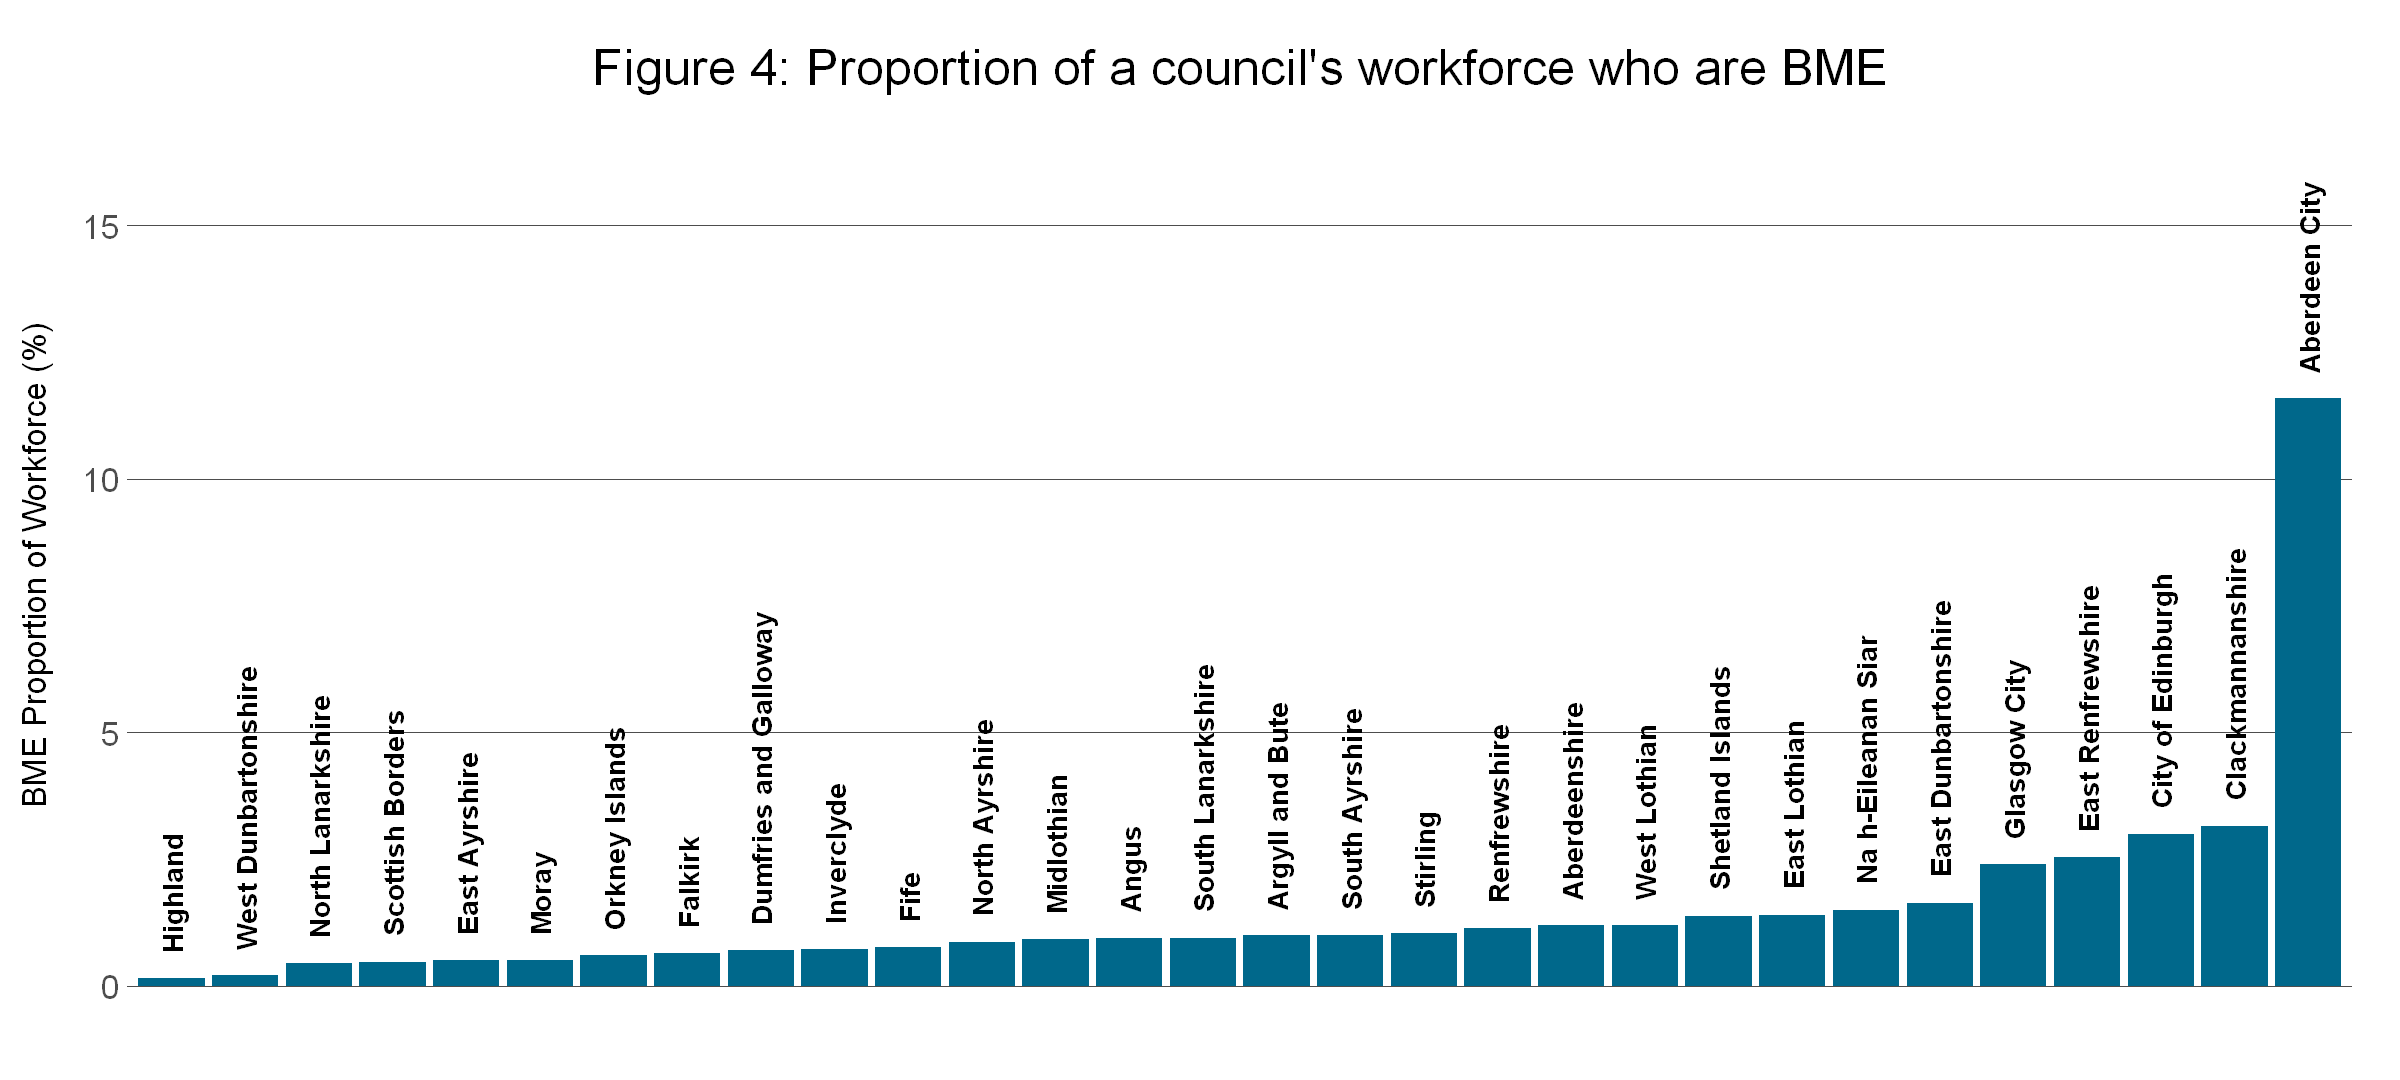

In [4]:
filter(scot, !is.na(bme)) %>%
mutate(lad19nm = reorder(lad19nm, bme)) %>%
ggplot()+
    geom_col(aes(x = lad19nm, y = bme), fill = "#00688b")+
    geom_text(aes(x = lad19nm, y = bme + 0.5, label = lad19nm), angle = 90, hjust = 0, size = 6, fontface = "bold")+
    ylim(c(0, max(scot$bme, na.rm = T) + 5))+
    labs(y = "BME Proportion of Workforce (%)", title = "Figure 4: Proportion of a council's workforce who are BME")+
    theme(axis.text.y = element_text(size = 20),
         axis.text.x = element_blank(),
         axis.title.y = element_text(size = 20, vjust = 5),
         axis.title.x = element_blank(),
         plot.title = element_text(size = 30, hjust = 0.5),
         axis.ticks = element_blank(),
         panel.background = element_blank(),
         panel.grid = element_blank(),
         panel.grid.major.y = element_line(color = "gray30"),
         plot.margin = unit(c(1,1,1,1), "cm")
         )



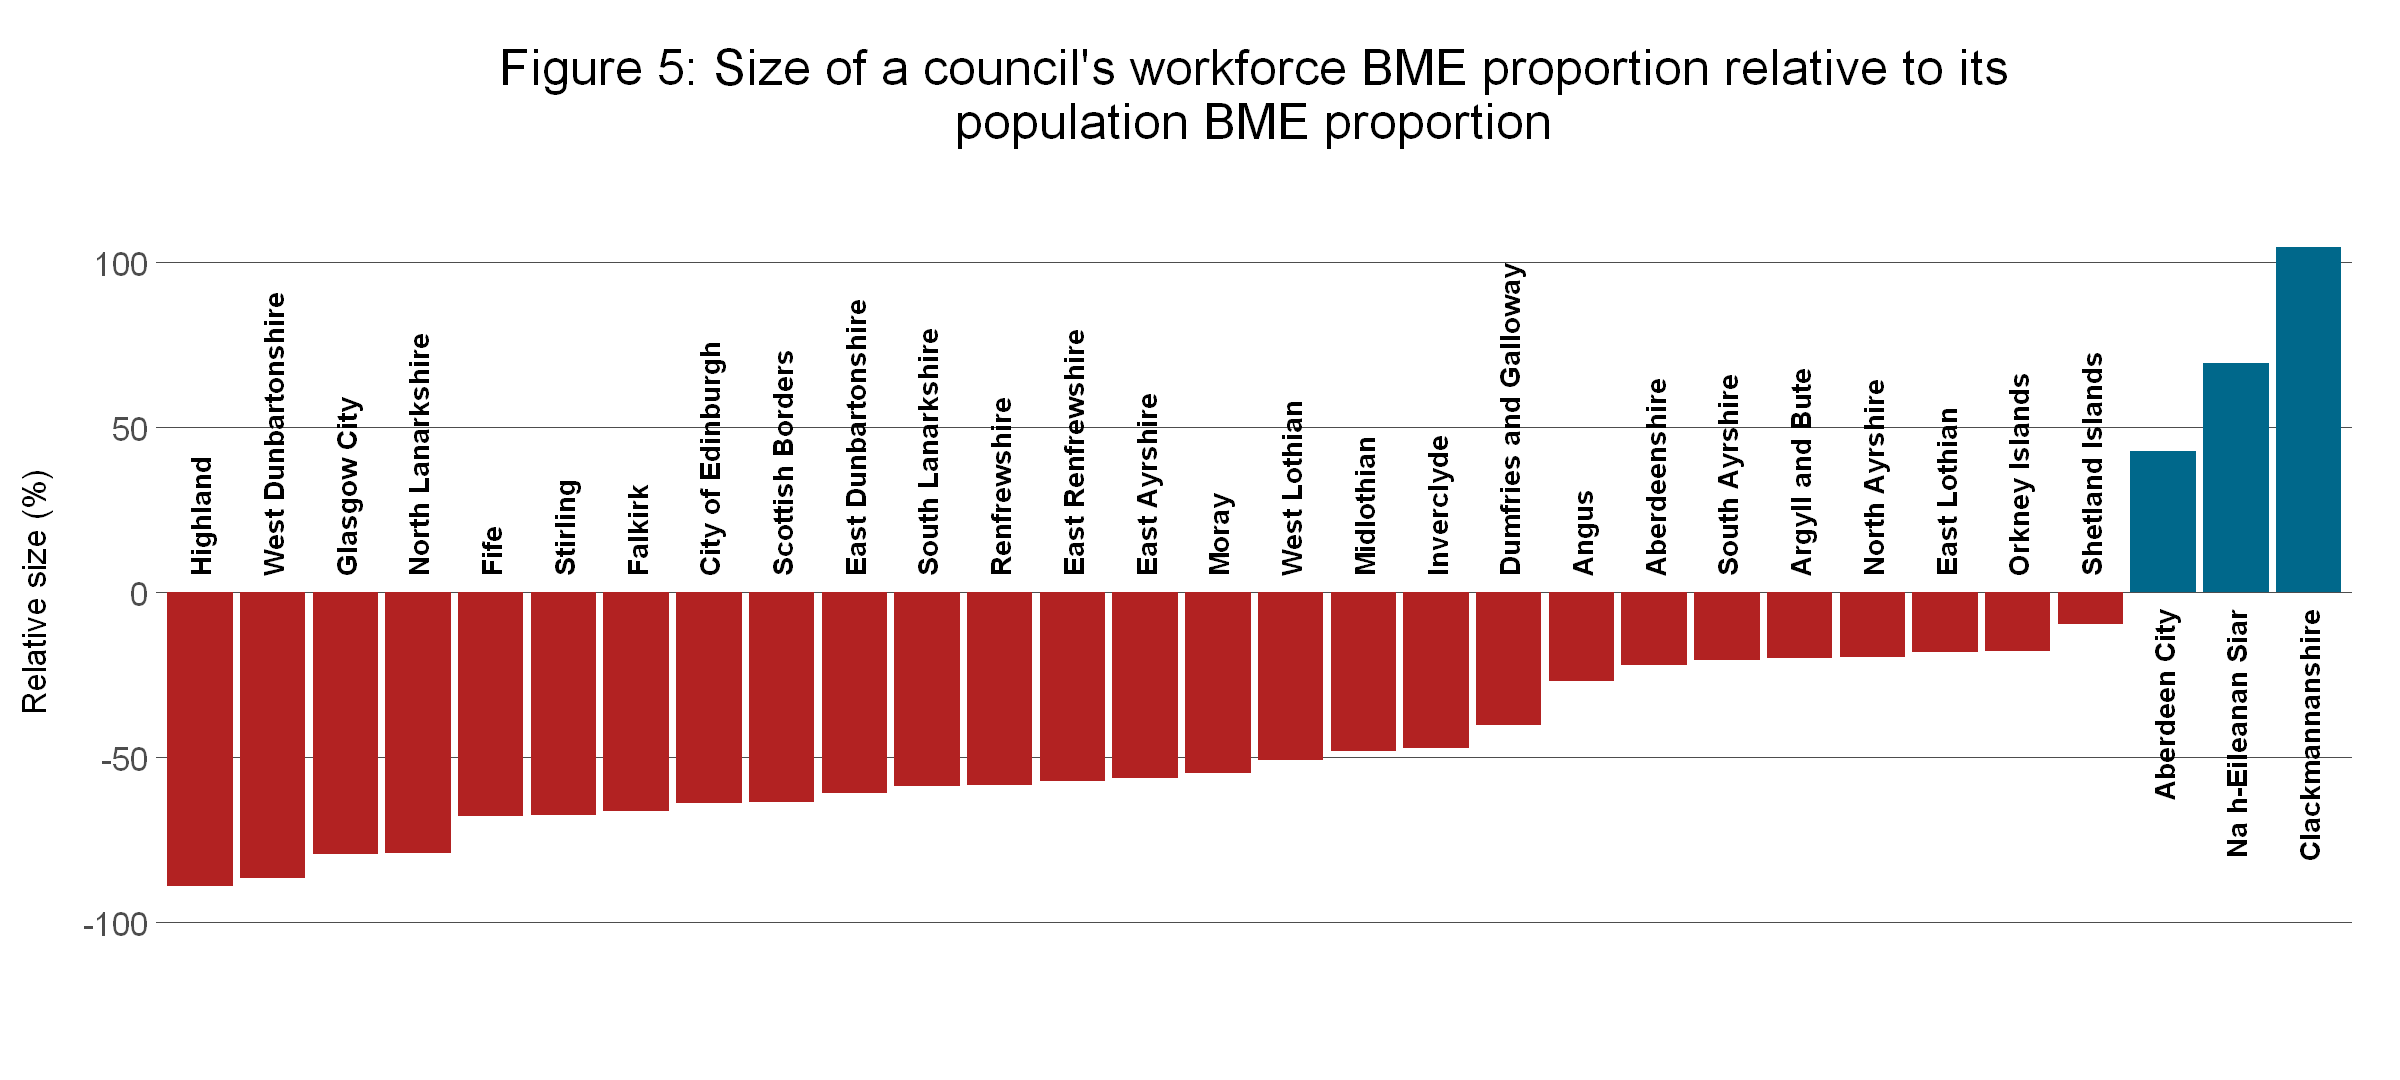

In [5]:
place_label<- function(p){
  ifelse(p>0, -5, 5)
}

adjust_label<- function(p){
  ifelse(p>0, 1, 0)
}

scot$percdiff_posneg[scot$percdiff>0]<- "pos"
scot$percdiff_posneg[scot$percdiff<0]<- "neg"

filter(scot, !is.na(percdiff)) %>%
  mutate(lad19nm = reorder(lad19nm, percdiff)) %>%
  ggplot()+
  geom_col(aes(x = lad19nm, y = percdiff, fill = percdiff_posneg))+
  geom_text(aes(x = lad19nm, y = place_label(percdiff), label = lad19nm, hjust = adjust_label(percdiff)), angle = 90, size = 6, fontface = "bold")+
  labs(y = "Relative size (%)", title = "Figure 5: Size of a council's workforce BME proportion relative to its\npopulation BME proportion")+
  ylim(c(-120, 120))+
  scale_fill_manual(values = c("firebrick", "#00688b"))+
  theme(axis.text.y = element_text(size = 20),
        axis.text.x = element_blank(),
        axis.title.y = element_text(size = 20, vjust = 5),
        axis.title.x = element_blank(),
        plot.title = element_text(size = 30, hjust = 0.5),
        axis.ticks = element_blank(),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        panel.grid.major.y = element_line(color = "gray30"),
        plot.margin = unit(c(1,1,1,1), "cm"),
        legend.position = "none"
  )


<p>Looking at the councils together in Figure 4, we can see that almost all the councils have workforce BME proportions lower than 2.5%. Aberdeen City Council is the clear outlier here, with 11.6% of its employees being from an ethnic minority background. What's more, Figure 5 shows that all but three of the councils have smaller BME proportion in the workforce than in their local populations. Aberdeen City, Eileanan Siar and Clackmannanshire are the exceptions, with BME individuals being represented in the workforce in greater proportions than in the population.</p>
<p>We could also visualise this with a scatter plot of workforce BME proportion against population BME proportion for each local authority, as in Figure 6. In this plot, we've shown the regression line for the councils in order to get an idea of the trend. Since Aberdeen City is such an outlier, as seen above, we've excluded it from the regression line. We can see that generally, the proportion of BME individuals in the workforce is roughly a third of the proportion in the population. Cit of Edinburgh and Glasgow City councils stand out as local authorities that have large BME populations that are underrepresented in the council workforce.

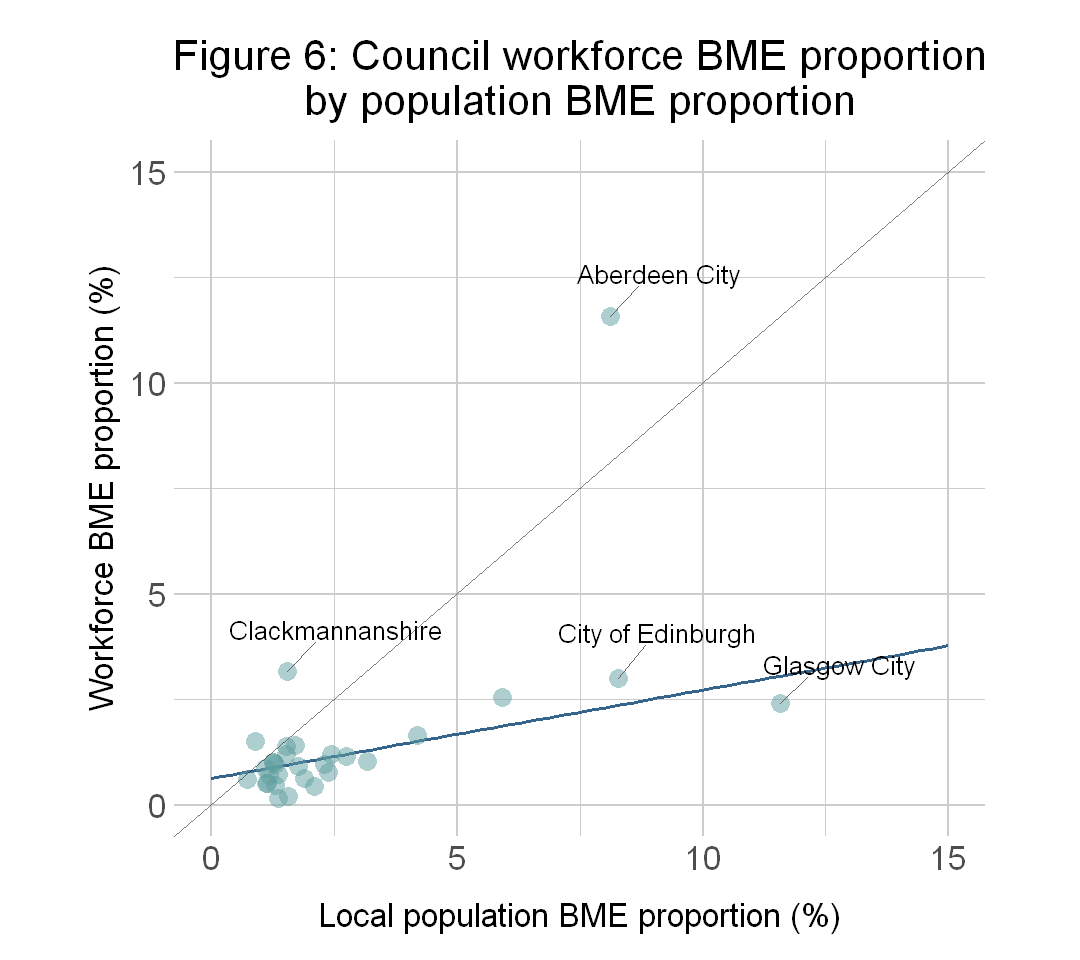

In [17]:
options(repr.plot.width = 9, repr.plot.height = 8)
filter(scot, !is.na(bme)) %>%
ggplot(aes(x = bmepop, y = bme))+
  geom_smooth(data = filter(scot, lad19nm != "Aberdeen City" & !is.na(bme)), method = "lm", formula = "y ~ x", se = FALSE, fullrange = TRUE, alpha = 0.2, color = "steelblue4", size = 1)+
  geom_point(shape = 16, color = "cadetblue", size = 5, alpha = 0.5)+
  geom_abline(slope = 1, intercept = 0, alpha = 0.5)+
  geom_text_repel(data = filter(scot, lad19nm == "Aberdeen City" | lad19nm == "Clackmannanshire" | lad19nm == "Glasgow City" | lad19nm == "City of Edinburgh"), aes(label = lad19nm), hjust = 0.5, size = 5.5, nudge_y = 1, nudge_x = 1, segment.color = "gray40")+
  ylim(c(0,15))+
  xlim(c(0,15))+
  labs(y = "Workforce BME proportion (%)", x = "Local population BME proportion (%)", title = "Figure 6: Council workforce BME proportion\nby population BME proportion")+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color = "gray80", size = 0.75),
        axis.ticks = element_blank(),
        axis.title.x = element_text(vjust = -2, size = 20),
        axis.title.y = element_text(vjust = 2, size = 20),
        axis.text = element_text(size = 20),
        plot.margin = unit(c(1,2,1,2), "cm"),
        plot.title = element_text(hjust = 0.5, vjust = 2, size = 25)
        )


## The unknown ethnicity proportions
<p> As we've noted above, substantial proportions of the workforce of some councils have an unknown ethnicity. This may be due to employees either having not responded to monitoring forms, or having responded but given a 'prefer not to say' answer to the ethnicity question. Equally, this can be due to the council having not sought ethnicity information from those employees. If this missing data is equally distributed across ethnic groups (and other variables), then we might argue that we can take the figures as generally representative of the ethnic profile (though it is still concerning that such large proportions of the workforce are missing in some cases). However, if missing data and non-disclosure of ethnicity by employees is more common in certain ethnic groups, then the proportions given in this data will be inaccurate. Some councils have speculated in their reports that if the 'unknown' proportion were to decrease then they might see an increase in their BME proportions, making the workforce more representative of the community. Were this to happen, it would imply that ethnic minority employees have a higher rate of missing data than White employees. However, this is not necessarily the case.</p>
<p>A more detailed exploration of this issue was the subject of my dissertation research, which sought to model non-disclosure of ethnicity in PSED data an elsewhere. It is beyond the scope of this notebook to look at the problem in detail, but one way that we can investigate this briefly is by looking at changes in the ethnic profile of councils. Since we do not have enough data over a sustained period of time (as we saw above), we simply look here at the changes between the latest two rounds of figures produced by each local authority.</p>
<p>Figure 7 plots the percentage change in the BME proportion (between the latest two rounds of figures) against the percentage change in the unknown proportion. Figure 8 does the same with the percentage changes in the White proportion and the unknown proportion. The percentage change, rather than the absolute change, so as to make the changes visually comparable the changes in the White proportion (which are much arger). If BME employees are overrepresented in the unknown data, we would expect changes in the unknown proportion to be negatively correlated with changes in the BME proportion.</p>

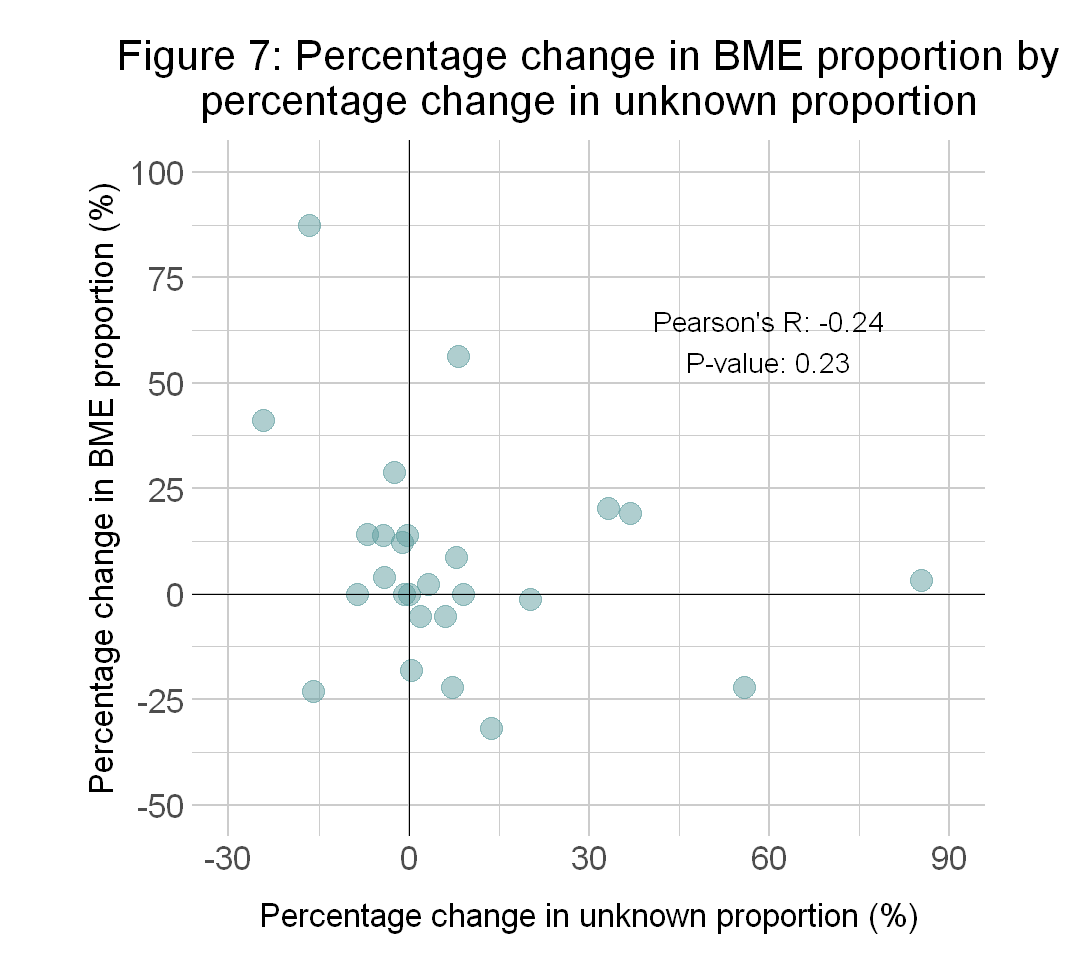

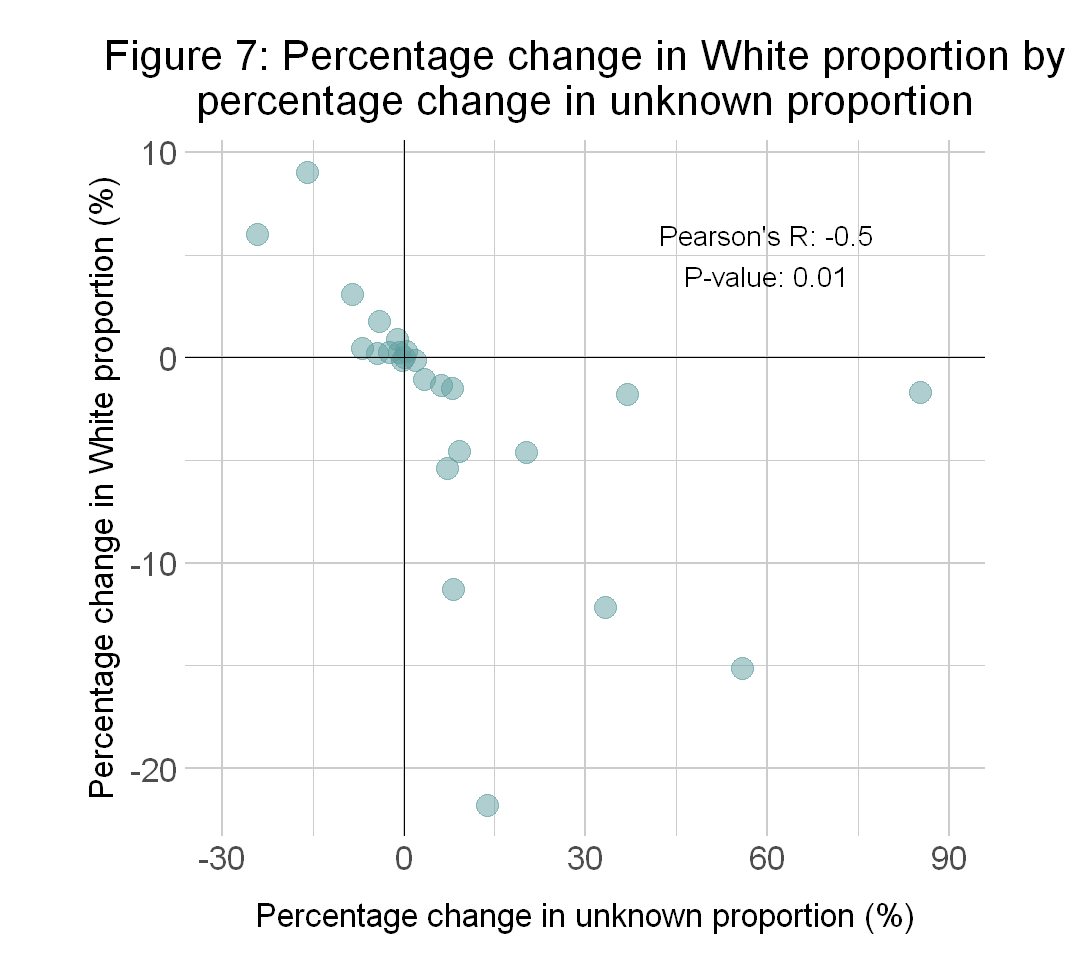

In [66]:
dffilt<- filter(df, !is.na(bme) & !is.na(unknown) & section != "Teaching")

dffilt<- group_by(dffilt, council)

l2<- top_n(dffilt, 2, wt = year)
l2<- left_join(l2, count(l2), by = "council")
l2<- filter(l2, n > 1)
l2<- l2[,c("council", "year", "bme", "white", "unknown", "bmepop")]
l2$position<- rep(c("latest", "second_latest"), 26)
l2w<- pivot_wider(l2, id_cols = c("council", "year"), names_from = "position", values_from = c("bme", "white", "unknown", "year", "bmepop"))
l2w$bme_change<- l2w$bme_latest - l2w$bme_second_latest
l2w$unknown_change<- l2w$unknown_latest - l2w$unknown_second_latest
l2w$white_change<- l2w$white_latest - l2w$white_second_latest
l2w$bmepd<- 100*l2w$bme_change/l2w$bme_second_latest
l2w$unknownpd<- 100*l2w$unknown_change/l2w$unknown_second_latest
l2w$whitepd<- 100*l2w$white_change/l2w$white_second_latest

l2w<- ungroup(l2w)

pearsons_bme<- cor.test(l2w$unknownpd, l2w$bmepd)
pearsons_white<- cor.test(l2w$unknownpd, l2w$whitepd)


ggplot(l2w, aes(x = unknownpd, y = bmepd))+
  geom_point(color = "cadetblue", size = 6, alpha = 0.5)+
  geom_vline(xintercept = 0)+
  geom_hline(yintercept = 0)+
  annotate(geom = "text", x = 60, y = 60, label = sprintf("Pearson's R: %g\nP-value: %g", round(pearsons_bme$estimate, 2), round(pearsons_bme$p.value, 2)), size = 6)+
  labs(x = "Percentage change in unknown proportion (%)", y = "Percentage change in BME proportion (%)", title = "Figure 7: Percentage change in BME proportion by\npercentage change in unknown proportion")+
  scale_x_continuous(limits = c(-30, 90), breaks = seq(-30,90, 30))+
  scale_y_continuous(limits = c(-50, 100), breaks = seq(-50,100, 25))+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color = "gray80", size = 0.75),
        axis.ticks = element_blank(),
        axis.title.x = element_text(vjust = -2, size = 20),
        axis.title.y = element_text(vjust = 2, size = 20),
        axis.text = element_text(size = 20),
        plot.margin = unit(c(1,2,1,2), "cm"),
        plot.title = element_text(hjust = 0.5, vjust = 2, size = 25)
        )


filter(l2w, !is.na(whitepd)) %>%
ggplot(aes(x = unknownpd, y = whitepd))+
  geom_point(color = "cadetblue", size = 6, alpha = 0.5)+
  geom_vline(xintercept = 0)+
  geom_hline(yintercept = 0)+
  annotate(geom = "text", x = 60, y = 5, label = sprintf("Pearson's R: %g\nP-value: %g", round(pearsons_white$estimate, 2), round(pearsons_white$p.value, 2)), size = 6)+
  labs(x = "Percentage change in unknown proportion (%)", y = "Percentage change in White proportion (%)", title = "Figure 7: Percentage change in White proportion by\npercentage change in unknown proportion")+
  scale_x_continuous(limits = c(-30, 90), breaks = seq(-30,90, 30))+
  theme(panel.background = element_blank(),
        panel.grid = element_line(color = "gray80", size = 0.75),
        axis.ticks = element_blank(),
        axis.title.x = element_text(vjust = -2, size = 20),
        axis.title.y = element_text(vjust = 2, size = 20),
        axis.text = element_text(size = 20),
        plot.margin = unit(c(1,2,1,2), "cm"),
        plot.title = element_text(hjust = 0.5, vjust = 2, size = 25)
        )



<p>Looking at Figure 7, there is no clear correlation between changes in the unknown proportion and in the BME proportion. Whilst for some councils, as the unknown proportion decreased, the BME proportion increased (and vice-versa), for many councils this did not occur. The weak Pearson's correlation coefficient and non-significant p-value confirm that there is not much evidence of a correlation (though given we are only look at 30 observations, we should not give too much weight to p-values here).<p/>
<p>Figure 8 does not show a very strong pattern, but there is nonetheless evidence of a negative correlation between the change in the unknown proportion and in the White proportion. All the councils are within the top-left or bottom-right quadrants, meaning that as the unknown proportion decreased the White proportion increased (or vice-versa). Additionally, the Person's correlation coeffiction shows a moderate and statistically significant negative correlation.</p>
<p>This would suggest, therefore, that rather than decreases in the unknown proportion resulting in increases in the BME proportion, it actually results in increases in the White proportion. This means that, based on this limited analysis, the data does not support the idea, as speculated by some councils, BME individuals are overrepresented in the unknown category.</p>

## Dashboard
Lastly, we can bring together some of the visualisations above into a dashboard for users to explore this data themselves. This can be done with a Shiny App, which is available to <a href = https://datavisualise.shinyapps.io/shinyapp1/ > view here.</a>
The aim with this dashboard, as with this notebook, is to bring together what as previously been disparate data published across different council websites and make it easy to get an overview of the situation and to compare across councils. As with much adminstrative data sources, t's important that we don't only collect data on ethnic diversity in councils but that we also explore it, analyse it and use it to inform policy!